<a href="https://colab.research.google.com/github/bassemr/DeepLearningAndGenerativeModelsCourse/blob/main/ex5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN vs MLP
In this notebook it will be showed how to train a CNN and what are its advantages (and disanvantages) with respect to a fully connected network.

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

torch.manual_seed(0)

In [116]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [117]:
a = torch.randn(3,3)
a.numel()

9

## Dataset Loading
First step we need to load the dataset that will be used for train and test.

In this case MNIST dataset will be used. MNIST consist in black and white images of handwritten digits between 0-9.

Pytorch Dataloaders will be used for this task.

In [118]:
!ls

data  res  sample_data


In [119]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('./data', train=True, download=True,
                       # transforms that we want to apply when iterating the dataset
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # mean and std of MNIST dataset
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# The dataloader will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=False)

In [120]:
print(len(train_dataset), len(train_loader)) #WHY?

60000 938


In [121]:
!mkdir -p res
!wget https://raw.githubusercontent.com/TFonta/DeepLearningAndGenerativeModelsCourse/main/res/plot_lib.py -O res/plot_lib.py


--2025-09-09 11:40:13--  https://raw.githubusercontent.com/TFonta/DeepLearningAndGenerativeModelsCourse/main/res/plot_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5017 (4.9K) [text/plain]
Saving to: ‘res/plot_lib.py’

res/plot_lib.py     100%[===================>]   4.90K  --.-KB/s    in 0s      

2025-09-09 11:40:13 (45.8 MB/s) - ‘res/plot_lib.py’ saved [5017/5017]



In [122]:
# plotting libs
from res.plot_lib import plot_data, plot_model, set_default
set_default()

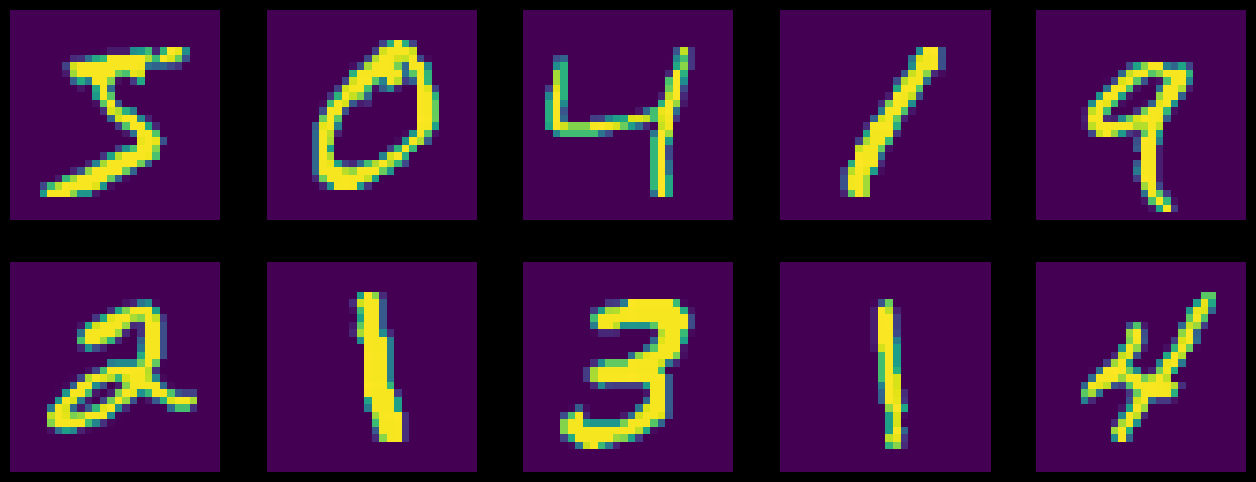

In [123]:
# show some images
def denorm_mnist(x):
    m = 0.1307
    std = 0.3081
    # denormalization operation = std*x + m
    return x*std + m

to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(denorm_mnist(image)))
    plt.axis('off')

## Network Definition
Let's define an MLP and a CNN to solve the MNIST digit classification task.

In [124]:
t= torch.randn(2,20,20)
t.view(-1,2).shape, nn.Flatten()(t).shape

(torch.Size([400, 2]), torch.Size([2, 400]))

In [125]:
# MLP
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        return self.network(x)

# CNN
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv_block1(x) # what is the output size?12
        x = self.conv_block2(x) # what is the output size?4
        x = x.view(-1, self.n_feature*4*4) # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [126]:
len(train_loader)

938

In [127]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [145]:
# define train and test function
accuracy_list = []
def train(epoch, model, optimizer, perm=None):
    train_loss = 0
    model.train()
    # dataloader will iterate the dataset and return images (data)
    # and labels (target)
    for batch_idx, (data, target) in enumerate(train_loader):

        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()           # add average per sample
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print(f"train_loss: {train_loss/len(train_loader)}")

def test(model, perm=None):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [129]:
len(train_loader)

938

In [146]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.282850
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.623367
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.255997
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.797050
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.824659
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.464226
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.684606
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.487644
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.400313
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.547074
train_loss: 0.8438195141870329

Test set: Average loss: 0.4154, Accuracy: 8808/10000 (88%)



In [147]:
# Training settings
n_features = 6 # number of feature maps


model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319079
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.077606
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.471333
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.315733
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.325085
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.215331
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.127566
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.318100
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.153578
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.240713
train_loss: 0.5614252062693142

Test set: Average loss: 0.1695, Accuracy: 9491/10000 (95%)



The CNN performs much better that an MLP on images.

Now let's try to shuffle the pixels!

In [132]:
perm.size()

torch.Size([784])

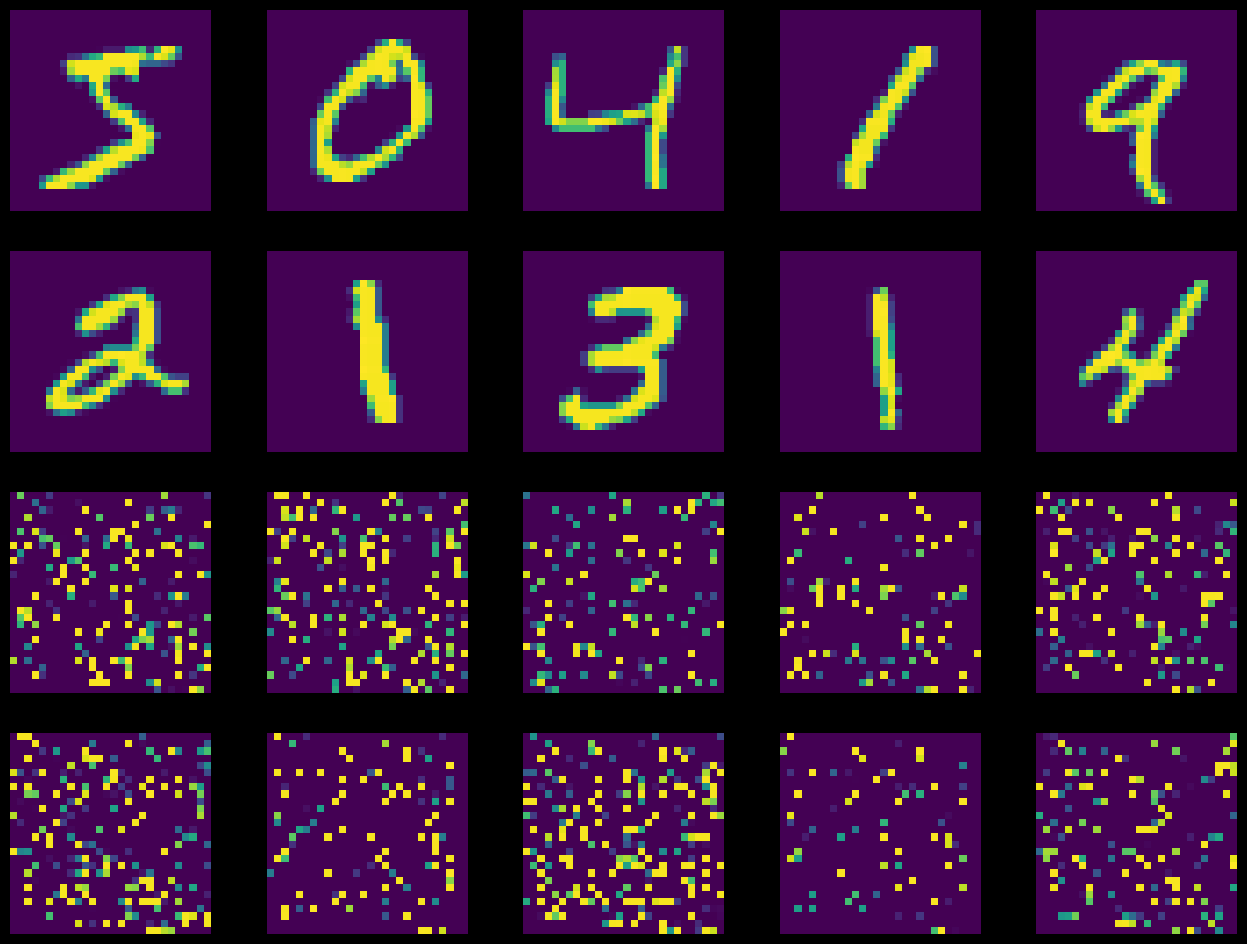

In [133]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(to_pil(denorm_mnist(image.squeeze())))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(to_pil(denorm_mnist(image_perm.squeeze())))
    plt.axis('off')

### How the CNN will perform now?

In [148]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304191
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.268930
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.160165
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.934260
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.357982
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.104520
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.835409
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.731025
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.933448
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.494432
train_loss: 1.354606275397069

Test set: Average loss: 0.6021, Accuracy: 8128/10000 (81%)



### How about the MLP?

In [149]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308785
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.676779
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.849634
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.718013
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.465942
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.354153
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.441306
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.427382
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.407529
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.412390
train_loss: 0.7584771108525649

Test set: Average loss: 0.4418, Accuracy: 8687/10000 (87%)



### The CNN performances dropped!!!
WHY? The concept of locality was lost: pixel are no longer stationary on a grid

In [150]:
accuracy_list

[88.08, 94.91, 81.28, 86.87]

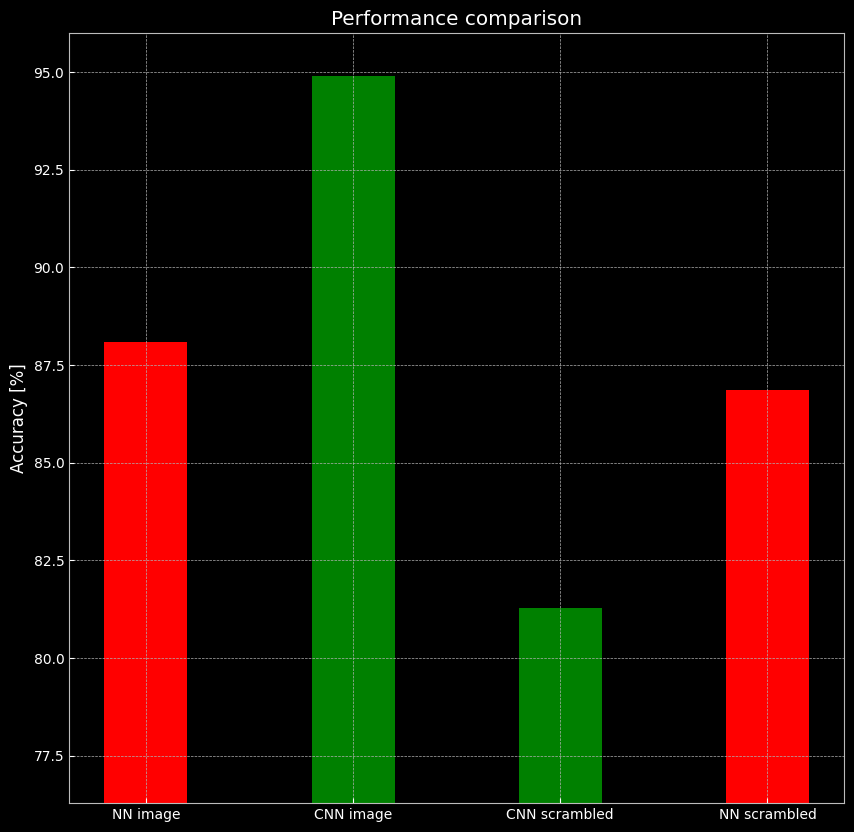

In [151]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4, color = ['red', 'green', 'green', 'red'])
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
plt.title('Performance comparison');